# Incidence of chickenpox in France

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

The data on the incidence of chickenpox are available from the Web site of the [Réseau Sentinelles](http://www.sentiweb.fr/). We download them as a file in CSV format, in which each line corresponds to a week in the observation period. Only the complete dataset, starting in 1991 and ending with a recent week, is available for download.

In [2]:
data_url = 'https://www.sentiweb.fr/datasets/incidence-PAY-7.csv'
data_file = "./incidence-PAY-7.csv"

import os
from urllib import request
if not os.path.exists(data_file):
    print('Offline data not available: attempt to retrieve database online')
    request.urlretrieve(data_url, data_file)
else:
    print('Offline data available.')

raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

Offline data available.


week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202238          7   1759        0    3539       3           0   
1     202237          7   1735      494    2976       3           1   
2     202236          7   1069      178    1960       2           1   
3     202235          7   1581      400    2762       2           0   
4     202234          7   2266      788    3744       3           1   
5     202233          7   7340        0   17399      11           0   
6     202232          7   7801     4086   11516      12           6   
7     202231          7   6896     4170    9622      10           6   
8     202230          7   9039     5770   12308      14           9   
9     202229          7  14851    10060   19642      22          15   
10    202228          7  15471    11028   19914      23          16   
11    202227          7  21191    16198   26184      32          24   
12    202226          7  16854    12806   20902      25          19   
13    202225          7  22246    18011   26481      34          28   
14    202224          7  22458    18105   26811      34          27   
15    202223          7  18772    14875   22669      28          22   
16    202222          7  18916    14941   22891      29          23   
17    202221          7  20310    16307   24313      31          25   
18    202220          7  23585    19004   28166      36          29   
19    202219          7  18593    14181   23005      28          21   
20    202218          7  17851    13963   21739      27          21   
21    202217          7  20314    16001   24627      31          24   
22    202216          7  19660    14860   24460      30          23   
23    202215          7  17799    13715   21883      27          21   
24    202214          7  17005    13162   20848      26          20   
25    202213          7  15448    11659   19237      23          17   
26    202212          7  14702    10794   18610      22          16   
27    202211          7  11729     8347   15111      18          13   
28    202210          7  13314    10036   16592      20          15   
29    202209          7  10485     7600   13370      16          12   
...      ...        ...    ...      ...     ...     ...         ...   
1630  199126          7  17608    11304   23912      31          20   
1631  199125          7  16169    10700   21638      28          18   
1632  199124          7  16171    10071   22271      28          17   
1633  199123          7  11947     7671   16223      21          13   
1634  199122          7  15452     9953   20951      27          17   
1635  199121          7  14903     8975   20831      26          16   
1636  199120          7  19053    12742   25364      34          23   
1637  199119          7  16739    11246   22232      29          19   
1638  199118          7  21385    13882   28888      38          25   
1639  199117          7  13462     8877   18047      24          16   
1640  199116          7  14857    10068   19646      26          18   
1641  199115          7  13975     9781   18169      25          18   
1642  199114          7  12265     7684   16846      22          14   
1643  199113          7   9567     6041   13093      17          11   
1644  199112          7  10864     7331   14397      19          13   
1645  199111          7  15574    11184   19964      27          19   
1646  199110          7  16643    11372   21914      29          20   
1647  199109          7  13741     8780   18702      24          15   
1648  199108          7  13289     8813   17765      23          15   
1649  199107          7  12337     8077   16597      22          15   
1650  199106          7  10877     7013   14741      19          12   
1651  199105          7  10442     6544   14340      18          11   
1652  199104          7   7913     4563   11263      14           8   
1653  199103          7  15387    10484   20290      27          18   
1654  199102          7  16277  

Are there missing data points? No, the dataset is complete.

In [3]:
raw_data[raw_data.isnull().any(axis=1)]

data = raw_data

Our dataset uses an uncommon encoding; the week number is attached
to the year number, leaving the impression of a six-digit integer.
That is how Pandas interprets it.

A second problem is that Pandas does not know about week numbers.
It needs to be given the dates of the beginning and end of the week.
We use the library `isoweek` for that.

Since the conversion is a bit lengthy, we write a small Python 
function for doing it. Then we apply it to all points in our dataset. 
The results go into a new column 'period'.

In [4]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

There are two more small changes to make.

First, we define the observation periods as the new index of
our dataset. That turns it into a time series, which will be
convenient later on.

Second, we sort the points chronologically.

In [5]:
sorted_data = data.set_index('period').sort_index()

We check the consistency of the data. Between the end of a period and
the beginning of the next one, the difference should be zero, or very small.
We tolerate an error of one second.

In [6]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

A first look at the data!

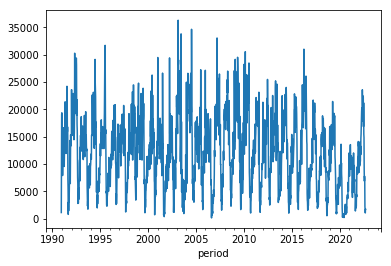

In [7]:
sorted_data['inc'].plot()

And a  zoom on the last few years.

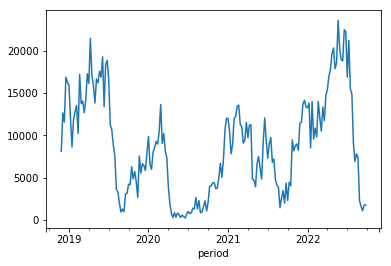

In [8]:
sorted_data['inc'][-200:].plot()

## Study of the annual incidence

Since the peaks of the epidemic happen in the first half of the year, we define the reference period for the annual incidence from September 1st of year $N$ to September 1st of year $N+1$.

Our task is a bit complicated by the fact that a year does not have an integer number of weeks. Therefore we modify our reference period a bit: instead of August 1st, we use the first day of the week containing September 1st.

A final detail: the dataset starts in week 49 of 1990 and it ends in week 38 of 2022, the first and last peaks are thus incomplete.

In [9]:
first_sept_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

Starting from this list of weeks that contain September 1st, we obtain intervals of approximately one year as the periods between two adjacent weeks in this list. We compute the sums of weekly incidences for all these periods.

We also check that our periods contain between 51 and 52 weeks, as a safeguard against potential mistakes in our code.

In [10]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_sept_week[:-1],
                        first_sept_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

And here are the annual incidences.

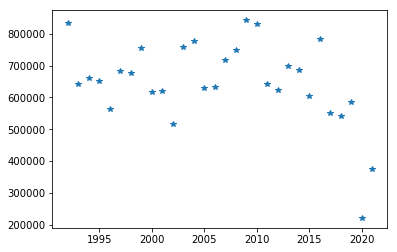

In [11]:
yearly_incidence.plot(style='*')

A sorted list makes it easier to find the highest values (at the end).

In [12]:
yearly_incidence.sort_values()

2020    221186
2021    376290
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64